In [1]:
###importing all dependancies
import numpy as np
import pandas as pd
from pathlib import Path
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import json
import datetime as dt
from prophet import Prophet

In [2]:
#reading in the DF
df=pd.read_csv(Path('../resources/Crime_Data_from_2020_to_Present.csv'))

In [3]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752911 entries, 0 to 752910
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           752911 non-null  int64  
 1   Date Rptd       752911 non-null  object 
 2   DATE OCC        752911 non-null  object 
 3   TIME OCC        752911 non-null  int64  
 4   AREA            752911 non-null  int64  
 5   AREA NAME       752911 non-null  object 
 6   Rpt Dist No     752911 non-null  int64  
 7   Part 1-2        752911 non-null  int64  
 8   Crm Cd          752911 non-null  int64  
 9   Crm Cd Desc     752911 non-null  object 
 10  Mocodes         649650 non-null  object 
 11  Vict Age        752911 non-null  int64  
 12  Vict Sex        654681 non-null  object 
 13  Vict Descent    654675 non-null  object 
 14  Premis Cd       752902 non-null  float64
 15  Premis Desc     752476 non-null  object 
 16  Weapon Used Cd  261472 non-null  float64
 17  Weapon Des

In [42]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%Y-%m-%d')

In [44]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'type_of_crime'],
      dtype='object')

In [46]:
#creating new DF only holding crime codes and thier description
code_crime=df[["Crm Cd", "Crm Cd Desc", "DATE OCC"]]
code_crime

,Crm Cd,Crm Cd Desc,DATE OCC
0,624,BATTERY - SIMPLE ASSAULT,2020-01-08
1,624,BATTERY - SIMPLE ASSAULT,2020-01-01
2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,2020-02-13
3,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),2020-01-01
4,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",2020-01-01
...,...,...,...
752906,662,"BUNCO, GRAND THEFT",2023-05-25
752907,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",2023-01-26
752908,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2023-03-22
752909,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2023-04-12


In [48]:
code_crime["Crm Cd"].unique()

array([624, 845, 745, 740, 121, 442, 946, 341, 330, 930, 648, 626, 440,
       354, 210, 230, 310, 510, 420, 761, 236, 662, 350, 860, 480, 623,
       956, 900, 888, 331, 901, 886, 421, 647, 940, 810, 922, 812, 220,
       625, 755, 649, 815, 251, 320, 850, 820, 668, 902, 664, 920, 343,
       437, 753, 928, 910, 760, 762, 661, 351, 821, 237, 903, 813, 666,
       627, 805, 763, 441, 122, 443, 450, 434, 410, 890, 520, 670, 951,
       660, 654, 352, 250, 110, 933, 652, 950, 231, 345, 822, 814, 932,
       622, 471, 235, 470, 921, 906, 433, 651, 943, 653, 436, 439, 806,
       949, 522, 446, 113, 438, 451, 485, 944, 954, 756, 942, 487, 473,
       347, 435, 880, 444, 475, 474, 931, 865, 349, 452, 353, 870, 924,
       840, 948, 884, 904, 830, 445, 432, 882], dtype=int64)

In [50]:
filtered_code_crime = code_crime.drop_duplicates(subset = "Crm Cd").sort_values('Crm Cd')

In [9]:
#creating a crime code DF that does not have duplicates

In [52]:
filtered_code_crime.to_csv("output.csv")

In [54]:
filtered_code_crime.reset_index(drop=True, inplace=True)
filtered_code_crime

,Crm Cd,Crm Cd Desc,DATE OCC
0,110,CRIMINAL HOMICIDE,2020-12-20
1,113,"MANSLAUGHTER, NEGLIGENT",2020-04-28
2,121,"RAPE, FORCIBLE",2020-01-01
3,122,"RAPE, ATTEMPTED",2020-01-02
4,210,ROBBERY,2020-01-14
...,...,...,...
133,949,ILLEGAL DUMPING,2020-10-05
134,950,"DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $...",2020-05-02
135,951,"DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 &...",2020-10-12
136,954,CONTRIBUTING,2020-12-01


In [91]:
filtered_code_crime["Crm Cd Desc"].unique()

array(['CRIMINAL HOMICIDE', 'MANSLAUGHTER, NEGLIGENT', 'RAPE, FORCIBLE',
       'RAPE, ATTEMPTED', 'ROBBERY', 'ATTEMPTED ROBBERY',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
       'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'CHILD NEGLECT (SEE 300 W.I.C.)',
       'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
       'SHOTS FIRED AT INHABITED DWELLING', 'BURGLARY',
       'BURGLARY, ATTEMPTED', 'BURGLARY FROM VEHICLE',
       'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'DISHONEST EMPLOYEE - GRAND THEFT',
       'GRAND THEFT / INSURANCE FRAUD', 'GRAND THEFT / AUTO REPAIR',
       'THEFT, PERSON', 'PURSE SNATCHING', 'PICKPOCKET', 'DRUNK ROLL',
       'THEFT OF IDENTITY', 'BURGLARY FROM VEHICLE, ATTEMPTED',
       'THEFT FRO

In [56]:
np.arange(187,368)

array([187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 36

In [87]:
# then catigorizing the crimes into violent or non-violent based off of https://leginfo.legislature.ca.gov's Title 8 and Title 9 violations which are crimes againsta person
filtered_code_crime.loc[filtered_code_crime["Crm Cd"].isin(np.arange(187,368)),"occurance_of_violent_crime"]=1
filtered_code_crime.head()

,Crm Cd,Crm Cd Desc,DATE OCC,type_of_crime,occurance_of_violent_crime
0,110,CRIMINAL HOMICIDE,2020-12-20,NaN,NaN
1,113,"MANSLAUGHTER, NEGLIGENT",2020-04-28,NaN,NaN
2,121,"RAPE, FORCIBLE",2020-01-01,NaN,NaN
3,122,"RAPE, ATTEMPTED",2020-01-02,NaN,NaN
4,210,ROBBERY,2020-01-14,violent,1


In [74]:
filtered_code_crime.loc[filtered_code_crime["Crm Cd"].isin(np.arange(187,368)),"occurance_of_violent_crime"]=1

In [78]:
df.loc[df["Crm Cd"].isin(np.arange(187,368)),"type_of_crime"]="violent"

In [80]:
df

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,type_of_crime
0,10304468,01/08/2020 12:00:00 AM,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978,NaN
1,190101086,01/02/2020 12:00:00 AM,2020-01-01,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545,NaN
2,200110444,04/14/2020 12:00:00 AM,2020-02-13,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474,NaN
3,191501505,01/01/2020 12:00:00 AM,2020-01-01,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019,NaN
4,191921269,01/01/2020 12:00:00 AM,2020-01-01,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752906,231510379,05/29/2023 12:00:00 AM,2023-05-25,1100,15,N Hollywood,1548,2,662,"BUNCO, GRAND THEFT",...,Invest Cont,662.0,NaN,NaN,NaN,5300 DENNY AV,NaN,34.1667,-118.3643,NaN
752907,231604807,01/27/2023 12:00:00 AM,2023-01-26,1800,16,Foothill,1663,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,12500 BRANFORD ST,NaN,34.2466,-118.4054,NaN
752908,231606525,03/22/2023 12:00:00 AM,2023-03-22,1000,16,Foothill,1602,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,Invest Cont,230.0,NaN,NaN,NaN,12800 FILMORE ST,NaN,34.2790,-118.4116,violent
752909,231210064,04/12/2023 12:00:00 AM,2023-04-12,1630,12,77th Street,1239,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,Invest Cont,230.0,NaN,NaN,NaN,6100 S VERMONT AV,NaN,33.9841,-118.2915,violent


<Axes: xlabel='DATE OCC'>

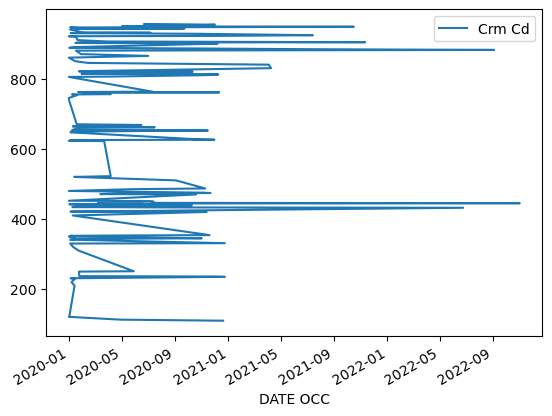

In [72]:
filtered_code_crime.plot(x="DATE OCC", y="Crm Cd")

#(x="DATE OCC", y="Crm Cd", kind="line", figsize=(30, 20))


In [99]:
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
#⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️
#⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️
#⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️
#⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️
#⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️
#⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️
#⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️
#⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️
#⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️
#⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️
#⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️)